# Project #2: Vehicle Price Prediction with TensorFlow

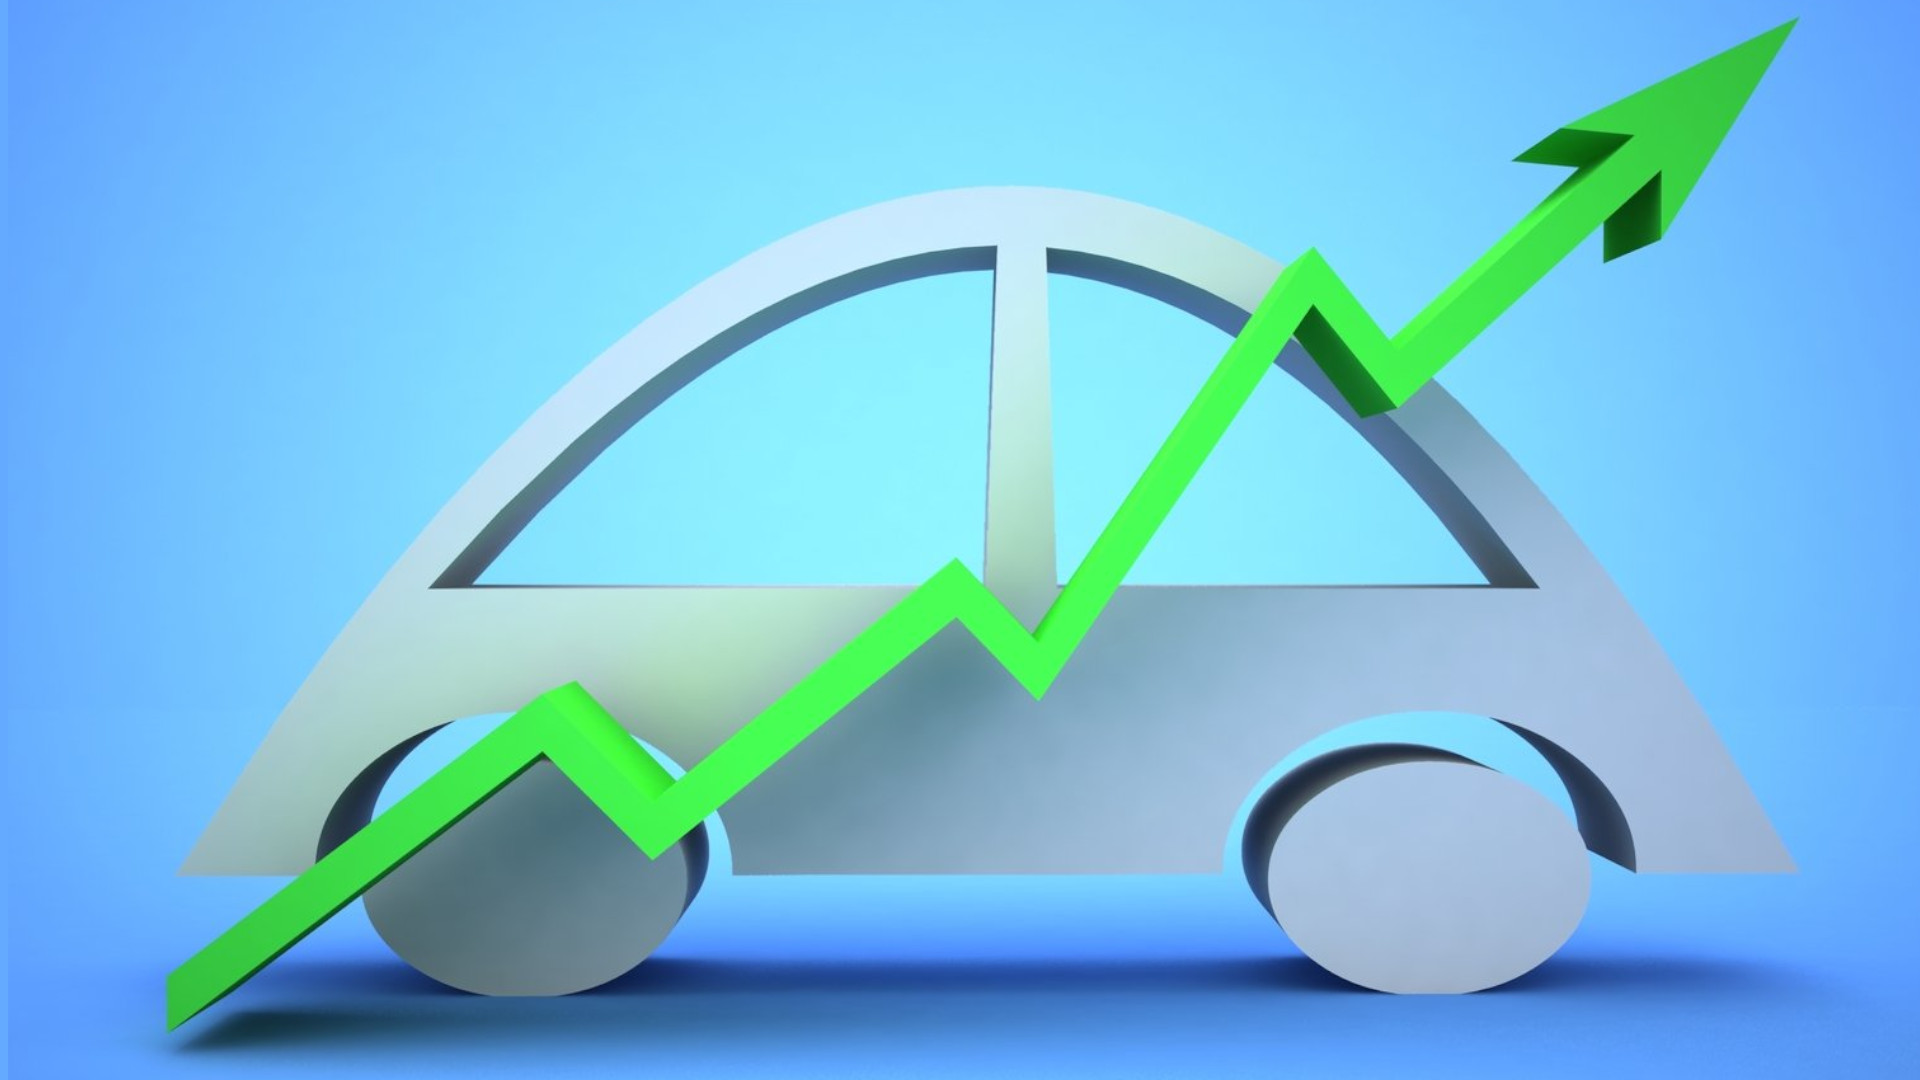

***
### Importing Dependencies

In [1]:
from tensorflow.keras.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import load_model, clone_model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mae

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

from google.colab.files import download
from warnings import filterwarnings
from scipy.stats import zscore

import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import os

In [2]:
sns.set(style = 'darkgrid', palette = 'bright')
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (12, 8)
filterwarnings(action = 'ignore')

***
### Dataset Description

- **ID -** Ad ID in the website.
- **City -** A city name where a vehicle is.
- **Vehicle Type -** The type of vehicles.
- **Brand -** A brand of a vehicle.
- **Model -** A model of a particular vehicle brand.
- **Year -** A year of production.
- **Color -** A color of a vehicle.
- **Engine -** An engine of a vehicle.
- **HP -** Horse power of a vehicle.
- **Fuel -** Fuel type of a vehicle.
- **Mileage -** Mileage of a vehicle.
- **Speed Box -** Speed box of a vehicle.
- **New -** Whether a vehicle is new or not.
- **Transmission -** Transmission of a vehicle.
- **Price -** Price(target variable) of a vehicle.
- **Date -** When a particular ad was placed on the website.
- **Seen -** The number of people that saw the ad.
- **Image Link -** A link to an image of a vehicle.
- **Link -** A link to a particular ad.
- **Saloon -** Whether or not it is a saloon vehicle.

***
### Importing Dataset

In [3]:
raw = pd.read_csv(filepath_or_buffer = 'Data.csv')
df = raw.copy()
df.head()

,ID,City,Vehicle Type,Brand,Model,Year,Color,Engine,HP,Fuel,Mileage,Speed Box,New,Transmission,Price,Date,Seen,Image Link,Link,Saloon
0,5511440,Bakı,Sedan,Audi,A5,2013,Ağ,2.0 L,211 hp,Benzin,145000 km,Variator,Xeyr,Ön,17700 $,23.09.2021,95,https://turbo.azstatic.com/uploads/f330x248/20...,https://turbo.az/autos/5511440-audi-a5,Şəxsi
1,5511282,Bakı,Hetçbek/Liftbek,Audi,A5,2012,Qara,2.0 L,211 hp,Benzin,182325 km,Avtomat,Xeyr,Tam,29000 AZN,23.09.2021,140,https://turbo.azstatic.com/uploads/f330x248/20...,https://turbo.az/autos/5511282-audi-a5,Şəxsi
2,5511120,Sumqayıt,Sedan,Audi,A6,2011,Qara,2.0 L,252 hp,Benzin,229000 km,Avtomat,Xeyr,Ön,15800 $,23.09.2021,156,https://turbo.azstatic.com/uploads/f460x343/20...,https://turbo.az/autos/5511120-audi-a6,Salon
3,5346751,Bakı,Hetçbek/Liftbek,Audi,A7,2012,Qəhvəyi,3.0 L,310 hp,Benzin,117000 km,Avtomat,Xeyr,Tam,24000 $,23.09.2021,9513,https://turbo.azstatic.com/uploads/f330x248/20...,https://turbo.az/autos/5346751-audi-a7,Şəxsi
4,5511023,Bakı,Sedan,Audi,A8,2002,Gümüşü,2.8 L,193 hp,Benzin,200000 km,Avtomat,Xeyr,Arxa,9300 AZN,23.09.2021,109,https://turbo.azstatic.com/uploads/f330x248/20...,https://turbo.az/autos/5511023-audi-a8,Şəxsi


Let's get initial information about the dataset.

In [4]:
display(df.info(), df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30057 entries, 0 to 30056
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            30057 non-null  int64 
 1   City          30057 non-null  object
 2   Vehicle Type  30057 non-null  object
 3   Brand         30057 non-null  object
 4   Model         30057 non-null  object
 5   Year          30057 non-null  int64 
 6   Color         30057 non-null  object
 7   Engine        30057 non-null  object
 8   HP            30057 non-null  object
 9   Fuel          30057 non-null  object
 10  Mileage       30057 non-null  object
 11  Speed Box     30057 non-null  object
 12  New           30057 non-null  object
 13  Transmission  30057 non-null  object
 14  Price         30057 non-null  object
 15  Date          30057 non-null  object
 16  Seen          30057 non-null  int64 
 17  Image Link    30057 non-null  object
 18  Link          30057 non-null  object
 19  Salo

None

,ID,Year,Seen
count,3.005700e+04,30057.000000,30057.000000
mean,5.438055e+06,2006.304821,2326.114183
std,1.452505e+05,8.471101,6106.335659
min,1.607113e+06,1961.000000,2.000000
25%,5.433828e+06,2000.000000,482.000000
50%,5.466893e+06,2008.000000,910.000000
75%,5.491001e+06,2013.000000,1920.000000
max,5.512244e+06,2021.000000,214288.000000


***
### Data Cleaning

Let's remove the potential extra spaces in variables & columns, replace spaces with underscores, lower them, and rename the Price variable.

In [5]:
print(f'The variables & columns before:\n\n {df.columns}\n')
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace(' ', '_')
df.rename(columns = lambda x: x.lower(), inplace = True)
df.rename(columns = {'price':'target'}, inplace = True)
print(f'The variables & columns now:\n\n {df.columns}')

The variables & columns before:

 Index(['ID', 'City', 'Vehicle Type', 'Brand', 'Model', 'Year', 'Color',
       'Engine', 'HP', 'Fuel', 'Mileage', 'Speed Box', 'New', 'Transmission',
       'Price', 'Date', 'Seen', 'Image Link', 'Link', 'Saloon'],
      dtype='object')

The variables & columns now:

 Index(['id', 'city', 'vehicle_type', 'brand', 'model', 'year', 'color',
       'engine', 'hp', 'fuel', 'mileage', 'speed_box', 'new', 'transmission',
       'target', 'date', 'seen', 'image_link', 'link', 'saloon'],
      dtype='object')


Since id, date, link and image_link variables will have no impact on target variable, let's drop them from the dataset.

In [6]:
print(f'The number of variables & columns before: {df.shape[1]}')
irrelevant_features = ['id', 'date', 'link', 'image_link']
df.drop(columns = irrelevant_features, inplace = True)
print(f'The number of variables & columns now: {df.shape[1]}')

The number of variables & columns before: 20
The number of variables & columns now: 16


Let's loop through each categoric variable & column and remove potential extra spaces.

In [7]:
for column in df.columns:
  if df[column].dtype == 'O':
    df[column] = df[column].str.strip()

Let's remove the **L, hp** and **km** words from the values of engine, hp and mileage variables.

In [8]:
df['mileage'] = df['mileage'].str.replace('km', '')
df['engine'] = df['engine'].str.replace('L', '')
df['hp'] = df['hp'].str.replace('hp', '')

Let's cast the data types of these variables.

In [9]:
converted_features = ['mileage', 'engine', 'hp']

for feature in converted_features:
  print(f'The data type of {feature} variable before: {df[feature].dtype}')

print()

df['mileage'] = pd.to_numeric(arg = df['mileage'], downcast = 'float')
df['engine'] = pd.to_numeric(arg = df['engine'], downcast = 'float')
df['hp'] = df['hp'].astype(dtype = 'int32')

for feature in converted_features:
  print(f'The data type of {feature} variable now: {df[feature].dtype}')

The data type of mileage variable before: object
The data type of engine variable before: object
The data type of hp variable before: object

The data type of mileage variable now: float32
The data type of engine variable now: float32
The data type of hp variable now: int32


Let's define a function that will cast the data type of target variable. Considering the fact that 1 Dollar is 1.7 Manat, the function will multiply the prices that are in US dollars by 1.7 to convert them into local currency whereas we will multiply the prices in euros with 2.0.

In [10]:
def convert_currency(price):
  """
  This is a function that will convert the prices in US currency to local
  currency.

  Args:
    price: Prices of a vehicle

  Returns:
    Converted currency
  """
  if '$' in price:
    price = float(price.replace('$', '').strip()) * 1.7
  elif '€' in price:
    price = float(price.replace('€', '').strip()) * 2.0
  else:
      price = float(price.replace('AZN', '').strip())
  return price

Let's apply the convert_currency function to the target variable.

In [11]:
print(f'The data type of target variable before: {df.target.dtype}')
df['target'] = df['target'].apply(convert_currency)
df['target'] = df['target'].astype(dtype = 'float32')
print(f'The data type of target variable now: {df.target.dtype}')

The data type of target variable before: object
The data type of target variable now: float32


Let's cast the data type of year variable to use it in exploratory data analysis as a datatime variable, however, we are going to cast its data type back to integer keeping only years which has huge impact on target variable.

In [12]:
print(f'The data type of year variable before: {df.year.dtype}')
df['year'] = df['year'].apply(lambda x: str(x) + '-01-01')
df['year'] = pd.to_datetime(arg = df['year'], yearfirst = True)
print(f'The data type of year variable now: {df.year.dtype}')

The data type of year variable before: int64
The data type of year variable now: datetime64[ns]


Let's find out the number of duplicates if there is any in the dataset.

In [13]:
print(f'The number of duplicates in the dataset: {df.duplicated().sum()}')

The number of duplicates in the dataset: 0


Let's find out if there is any missing value in the dataset and use Heatmap to visualize it.

In [14]:
pd.Series(data = pd.isnull(df).sum(), name = 'NA').to_frame()

,NA
city,0
vehicle_type,0
brand,0
model,0
year,0
color,0
engine,0
hp,0
fuel,0
mileage,0


Let's use the heatmap to visually display that there is no missing value present in the data.

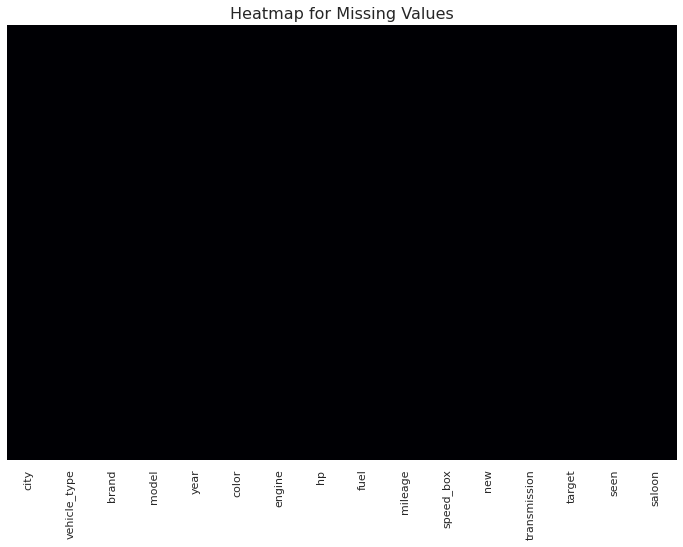

In [15]:
sns.heatmap(data = df.isnull(), yticklabels = False, cbar = False, cmap = plt.cm.magma)
plt.title(label = 'Heatmap for Missing Values', fontsize = 16)
plt.show()

Any value that has **z score** either greater than positive 3 or lower than negative 3 is an outlier and we can either drop, impute or let outliers be present in the dataset as they are. We are going to use Inter Quartile Range(IQR) method to handle outliers.

In [16]:
numeric_features = ['hp', 'engine', 'seen', 'mileage', 'target']

print(f'The number of total records that contain outlier(s) before: {df.loc[(abs(zscore(df[numeric_features])) > 3).any(axis = 1)].shape[0]}')

def impute_outliers(value):
  """
  This is a function that will impute the outliers using Inter Quartile Range(IQR)
  method which means that if a value if greater than the upperlimit or smaller than
  lowerlimit it will automatically be replaced either with upperlimit or lowerlimit
  value.

  Args:
    value: The values of numeric features.

  Returns:
    Imputed values with no outliers.
  """
  if value > upperlimit:
    value = upperlimit
  elif value < lowerlimit:
    value = lowerlimit
  return value

for numeric_feature in numeric_features:
  Q3 = df[numeric_feature].quantile(q = 0.75)
  Q1 = df[numeric_feature].quantile(q = 0.25)
  IQR = Q3 - Q1
  outlier_range = IQR * 1.5
  upperlimit = Q3 + outlier_range
  lowerlimit = Q1 - outlier_range
  df[numeric_feature] = df[numeric_feature].apply(impute_outliers)

while df.loc[(abs(zscore(df[numeric_features])) > 3).any(axis = 1)].shape[0] != 0:
  df.drop(index = df.loc[(abs(zscore(df[numeric_features])) > 3).any(axis = 1)].index, inplace = True)

print(f'The number of total records that contain outlier(s) now: {df.loc[(abs(zscore(df[numeric_features])) > 3).any(axis = 1)].shape[0]}')

The number of total records that contain outlier(s) before: 1614
The number of total records that contain outlier(s) now: 0


Let's reallocate the features.

In [17]:
NUMERIC_FEATURES = [variable for variable in df.columns if df[variable].dtype != 'O' and variable not in ['year', 'target']]
CATEGORIC_FEATURES = [variable for variable in df.columns if df[variable].dtype == 'O']
DATETIME_FEATURE = ['year']
TARGET_FEATURE = ['target']

reallocated_features = CATEGORIC_FEATURES + NUMERIC_FEATURES + DATETIME_FEATURE + TARGET_FEATURE
df = df[reallocated_features]

***
### Data Preprocessing

Let's cast the data type of **year** variable back to integer by keeping only the years.

In [18]:
print(f'The data type of year variable before: {df.year.dtype}')
df['year'] = df['year'].apply(lambda x: int(str(x)[:4]))
print(f'The data type of year variable now: {df.year.dtype}')

The data type of year variable before: datetime64[ns]
The data type of year variable now: int64


Let's drop the **seen** variable from the dataset.

In [19]:
print(f'The number of variables before: {df.shape[1]}')
df.drop(columns = 'seen', inplace = True)
print(f'The number of variables now: {df.shape[1]}')

The number of variables before: 16
The number of variables now: 15


Let's split the data into features and labels.

In [20]:
X = df.iloc[:, :-1]
Y = df.iloc[:, -1]

Let's map the values of **city, vahicle_type, speed_box, fuel, brand, model, color, new** and **saloon** variables.

In [21]:
X.loc[~X['vehicle_type'].isin(['Sedan', 'Offroader/SUV', 'Hetçbek/Liftbek']), 'vehicle_type'] = 'Other'
X.loc[~X['brand'].isin(['Mercedes', 'LADA (VAZ)', 'Toyota']), 'brand'] = 'Other'
X.loc[~X['speed_box'].isin(['Avtomat', 'Mexaniki']), 'speed_box'] = 'Other'
X.loc[~X['model'].isin(['Cruze', '2107', 'Astra']), 'model'] = 'Other'
X.loc[~X['color'].isin(['Ağ', 'Qara', 'Gümüşü']), 'color'] = 'Other'
X.loc[~X['fuel'].isin(['Benzin', 'Dizel']), 'fuel'] = 'Other'
X['saloon'] = X['saloon'].map({'Şəxsi':0, 'Salon':1})
X['new'] = X['new'].map({'Bəli':1, 'Xeyr':0})
X.loc[X['city'] != 'Bakı', 'city'] = 'Other'
X['city'] = X['city'].map({'Bakı':1, 'Other':0})

Let's apply **one hot encoding** to handle categoric variables.

In [22]:
print(f'The number of features before: {X.shape[1]}')
X = pd.get_dummies(data = X, drop_first = True)
features_list = X.columns
print(f'The number of features now: {X.shape[1]}')

The number of features before: 14
The number of features now: 25


Let's convert features and labels into numpy arrays and cast their data type to **float32** since neural networks tend to perform better with this particular data type.

In [23]:
X = X.to_numpy(dtype = np.float32)
Y = Y.to_numpy(dtype = np.float32)

Let's split the features and labels into train and validation set with **80/20** ratio.

In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size = 0.2, random_state = 42)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((24045, 25), (24045,), (6012, 25), (6012,))

Let's apply **feature scaling** to train and validation set features since neural nets require input data in a scaled format.

In [25]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

Let's define a function that will create a list of callbacks to prevent overfitting.

In [26]:
def model_callbacks(model_path, monitoring_metric = 'val_loss', tolerance = 20, verbosity = 1):
  """
  This is a function that will create an early stopping and a model checkpoint
  callbacks to prevent overfitting.

  Args:
    model_path: A path to a model instance with h5 extension.
    monitoring_metric: A metric to keep track of during training.
    tolerance: A level of tolerance in case model does not improve.
    verbosity: A level of verbosity to display the output.

  Returns:
    A list of callbacks.
  """
  stop = EarlyStopping(monitor = monitoring_metric, patience = tolerance, restore_best_weights = True, verbose = verbosity)
  save = ModelCheckpoint(filepath = model_path, monitor = monitoring_metric, save_best_only = True, verbose = verbosity)
  callbacks = [stop, save]
  return callbacks

***
### Modelling: Feed Forward Deep Neural Network (DNN)

Let's build a Feed Forward Deep Neural Network (DNN) model with **Sequential** API.

In [27]:
# Setting a global seed to maintain reproducibility
tf.random.set_seed(seed = 42)

# Building a Feed Forward Deep Neural Network (DNN) model with Sequential API
model_1 = Sequential(layers = [
                     Dense(units = 256, activation = 'relu'),
                     Dense(units = 256, activation = 'relu'),
                     Dense(units = 256, activation = 'relu'),
                     Dropout(rate = 0.2, seed = 42),
                     Dense(units = 512, activation = 'relu'),
                     Dense(units = 512, activation = 'relu'),
                     Dense(units = 512, activation = 'relu'),
                     Dropout(rate = 0.2, seed = 42),
                     Dense(units = 512, activation = 'relu'),
                     Dense(units = 512, activation = 'relu'),
                     Dense(units = 512, activation = 'relu'),
                     Dropout(rate = 0.2, seed = 42),
                     Dense(units = 256, activation = 'relu'),
                     Dense(units = 256, activation = 'relu'),
                     Dense(units = 256, activation = 'relu'),
                     Dropout(rate = 0.2, seed = 42),
                     Dense(units = 1)
], name = 'Feed_Forward_DNN')

# Compiling the model
model_1.compile(optimizer = Adam(), loss = mae)

# Fitting the model
model_training_1 = model_1.fit(x = X_train, y = y_train, batch_size = 32, 
                               epochs = 500, validation_data = (X_valid, y_valid),
                               callbacks = model_callbacks(model_path = f'{model_1.name}.h5'),
                               verbose = 1)

Epoch 1/500
748/752 [============================>.] - ETA: 0s - loss: 4070.0918
Epoch 00001: val_loss improved from inf to 2664.42334, saving model to Feed_Forward_DNN.h5
752/752 [==============================] - 10s 8ms/step - loss: 4066.1431 - val_loss: 2664.4233
Epoch 2/500
746/752 [============================>.] - ETA: 0s - loss: 3330.9368
Epoch 00002: val_loss improved from 2664.42334 to 2512.12378, saving model to Feed_Forward_DNN.h5
752/752 [==============================] - 6s 8ms/step - loss: 3327.7434 - val_loss: 2512.1238
Epoch 3/500
751/752 [============================>.] - ETA: 0s - loss: 3076.2781
Epoch 00003: val_loss did not improve from 2512.12378
752/752 [==============================] - 6s 8ms/step - loss: 3076.3496 - val_loss: 3762.4309
Epoch 4/500
750/752 [============================>.] - ETA: 0s - loss: 3067.3552
Epoch 00004: val_loss did not improve from 2512.12378
752/752 [==============================] - 6s 8ms/step - loss: 3068.3450 - val_loss: 2971.172

In [28]:
# Displaying the summary of the model
model_1.summary()

Model: "Feed_Forward_DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               6656      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 512)               131584    
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dense_5 (Dense)             (None, 512)          

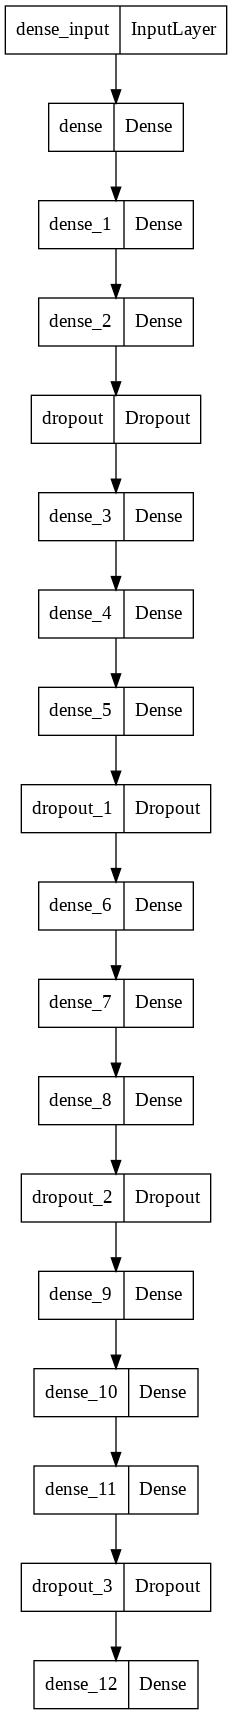

In [29]:
# Displaying the architecture of the model
plot_model(model = model_1, to_file = f'{model_1.name}.png')

Let's visualize the model performance per epoch.

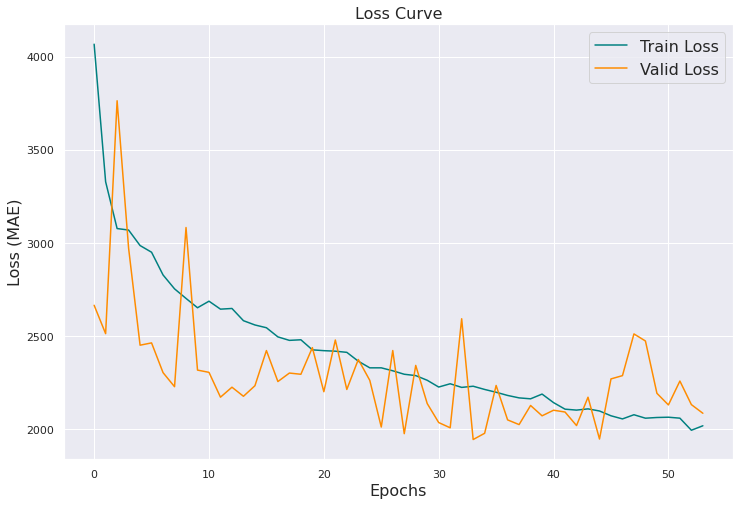

In [30]:
valid_loss = model_training_1.history['val_loss']
train_loss = model_training_1.history['loss']

plt.plot(train_loss, label = 'Train Loss', c = 'teal')
plt.plot(valid_loss, label = 'Valid Loss', c = 'darkorange')
plt.title(label = 'Loss Curve', fontsize = 16)
plt.ylabel(ylabel = 'Loss (MAE)', fontsize = 16)
plt.xlabel(xlabel = 'Epochs', fontsize = 16)
plt.legend(loc = 'best', fontsize = 16)
plt.show()

Let's define a function that will visually compare the predicted values to ground truth values.

In [31]:
def visually_compare(y_true, y_pred, model_name = None):
  """
  This is a function that will visually compare the predicted values to ground
  truth values.

  Args:
    y_true: Ground truth values.
    y_pred: Predicted values.
    model_name: A name of a model.

  Returns:
    A two-dimensional plot.
  """
  data_dictionary = {'Ground Truths':y_true, 'Predictions':y_pred}
  pd.DataFrame(data = data_dictionary).sample(n = 10, random_state = 42).plot(kind = 'bar', color = ['teal', 'darkorange'])
  plt.title(label = f'{model_name} Model Performance', fontsize = 16)
  plt.ylabel(ylabel = 'Vehicle Price(AZN)', fontsize = 16)
  plt.legend(loc = 'best', fontsize = 16)
  plt.show()

Let's load the best model, make predictions and visually compare the predicted values to ground truth values.

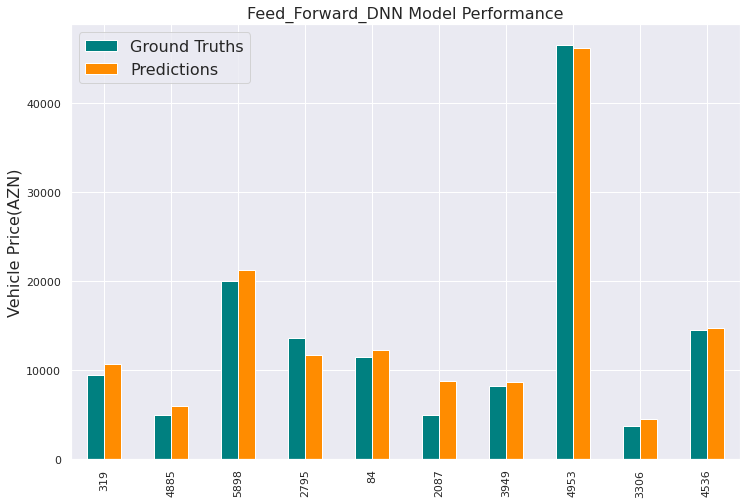

In [32]:
model_1 = load_model(filepath = f'{model_1.name}.h5')
model_1_predictions = tf.squeeze(input = model_1.predict(x = X_valid)).numpy()
visually_compare(y_true = y_valid, y_pred = model_1_predictions, model_name = model_1.name)

Let's define a function that will load and evaluate the model performance using various regression evaluation metrics such as **R Squared, Adjusted R Squared, MAE, MSE, RMSE** and **MAPE**.

In [33]:
def evaluate_model_performance(y_true, y_pred, N = X.shape[0], p = X.shape[1], model_name = None):
  """
  This is a function that will load and evaluate the model performance using
  various regression evaluation metrics such as MAE, MSE, RMSE and MAPE.

  Args:
    y_true: Ground truth values.
    y_pred: Predicted values.
    N: The number of total records.
    p: The number of independent features.
    model_name: A name of a model.
  
  Returns:
    A pandas dataframe.
  """
  MAPE = mean_absolute_percentage_error(y_true = y_true, y_pred = y_pred).numpy()
  MAE = mean_absolute_error(y_true = y_true, y_pred = y_pred).numpy()
  MSE = mean_squared_error(y_true = y_true, y_pred = y_pred).numpy()
  R_SQUARED = r2_score(y_true = y_true, y_pred = y_pred)
  AD_R_SQUARED = 1 - (((1 - R_SQUARED) * (N - 1)) / (N - p - 1))
  RMSE = tf.math.sqrt(x = MSE).numpy()

  df = pd.DataFrame(columns = ['R_Squared', 'Adjusted_R_Squared', 'MAPE', 'MAE', 'MSE', 'RMSE'], index = [model_name + ' Model'])
  df['R_Squared'] = R_SQUARED
  df['Adjusted_R_Squared'] = AD_R_SQUARED
  df['MAPE'] = MAPE
  df['MAE'] = MAE
  df['MSE'] = MSE
  df['RMSE'] = RMSE

  for column in df.columns:
    df[column] = df[column].apply(lambda x: round(number = x, ndigits = 2))

  return df

Let's call the function and evaluate its overall performance using various regression evaluation metrics.

In [34]:
model_1_df = evaluate_model_performance(y_true = y_valid, y_pred = model_1_predictions, model_name = model_1.name)
model_1_df

,R_Squared,Adjusted_R_Squared,MAPE,MAE,MSE,RMSE
Feed_Forward_DNN Model,0.93,0.93,13.63,1943.68,11661530.0,3414.9


Let's define a function that will create a list of models to form an ensemble model.

In [35]:
def create_ensemble_model(num_models = 10):
  """
  This is a function that will create a list of models to form an Ensemble model.

  Args:
    num_models: The number of models to form an ensemble model.

  Returns:
    A list of models.
  """
  models = []

  for x in range(1, num_models + 1):
    model = clone_model(model = model_1)
    model.compile(optimizer = Adam(), loss = mae)
    model_training = model.fit(x = X_train, y = y_train, batch_size = 32, 
                               epochs = 500, validation_data = (X_valid, y_valid),
                               callbacks = model_callbacks(model_path = f'Model_{x}.h5', verbosity = 0),
                               verbose = 0)
    models.append(model)

  return models

Let's call the function and create an ensemble model.

In [36]:
ensemble_model = create_ensemble_model()
print(f'The number of models in the Ensemble Model: {len(ensemble_model)}')

The number of models in the Ensemble Model: 10


Let's load each model in the ensemble model, make predictions, aggregate them and visually compare the predicted values to ground truth values.

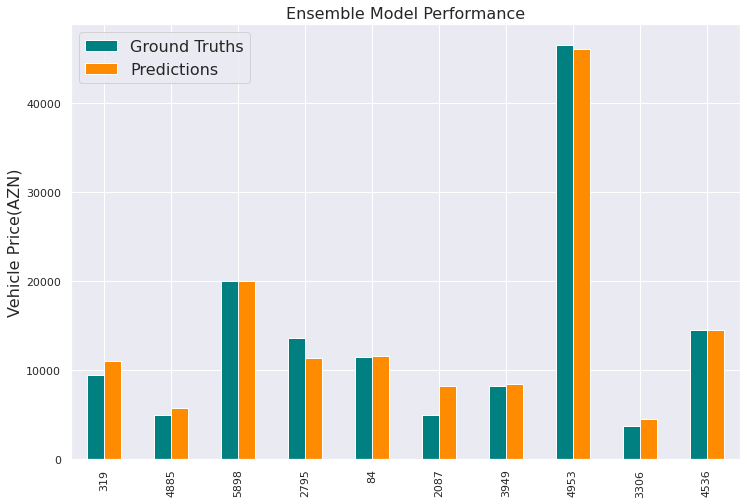

In [37]:
model_predictions = []
models_paths = [model for model in os.listdir() if model.startswith('Model_')]

for model_path in models_paths:
  model = load_model(filepath = model_path)
  model_prediction = tf.squeeze(input = model.predict(x = X_valid)).numpy()
  model_predictions.append(model_prediction)

aggregated_model_predictions = tf.math.reduce_mean(input_tensor = model_predictions, axis = 0).numpy()

visually_compare(y_true = y_valid, y_pred = aggregated_model_predictions, model_name = 'Ensemble')

Let's evaluate the performance of the ensemble model using various regression evaluation metrics such as **R Squared, Adjusted R Squared, MAPE, MAE, MSE** and **RMSE**.

In [38]:
model_2_df = evaluate_model_performance(y_true = y_valid, y_pred = aggregated_model_predictions, model_name = 'Ensemble')
model_2_df

,R_Squared,Adjusted_R_Squared,MAPE,MAE,MSE,RMSE
Ensemble Model,0.94,0.94,12.96,1843.82,10580072.0,3252.7


Let's compare the models.

In [39]:
summary_df = pd.concat(objs = [model_1_df, model_2_df], axis = 0)
summary_df.sort_values(by = ['R_Squared', 'Adjusted_R_Squared', 'MAE'], ascending = [False, False, True], inplace = True)
summary_df

,R_Squared,Adjusted_R_Squared,MAPE,MAE,MSE,RMSE
Ensemble Model,0.94,0.94,12.96,1843.82,10580072.0,3252.7
Feed_Forward_DNN Model,0.93,0.93,13.63,1943.68,11661530.0,3414.9


Let's define a function to make a prediction on custom data.

In [40]:
def make_prediction(input_data, feature_scaler, models):
  """
  This is a function that will make a prediction on custom data using the
  ensemble model.

  Args:
    input_data: A list of input data.
    feature_scaler: A feature scaling instance.
    models: A list of models that form the ensemble model.

  Returns:
    Prints out the model's prediction.
  """
  model_predictions = []
  data = np.array(object = [input_data], dtype = np.float32)

  for model_path in models:
    model = load_model(filepath = model_path)
    model_prediction = tf.squeeze(input = model.predict(x = feature_scaler.transform(X = data))).numpy()
    model_predictions.append(model_prediction)

  aggregated_model_prediction = tf.cast(x = tf.math.round(x = tf.math.reduce_mean(input_tensor = model_predictions)), dtype = tf.int32).numpy()
  upper_aggregated_prediction = round(number = aggregated_model_prediction + 1843.82)
  lower_aggregated_prediction = round(number = aggregated_model_prediction - 1843.82)

  print(f'Input --> {input_data} Output --> {aggregated_model_prediction} AZN')
  print(f'Prediction Interval --> [{lower_aggregated_prediction} AZN - {upper_aggregated_prediction} AZN]')

Let's display the first five records of features dataset.

In [41]:
pd.DataFrame(data = X, columns = features_list).head()

,city,new,saloon,engine,hp,mileage,year,vehicle_type_Offroader/SUV,vehicle_type_Other,vehicle_type_Sedan,brand_Mercedes,brand_Other,brand_Toyota,model_Astra,model_Cruze,model_Other,color_Gümüşü,color_Other,color_Qara,fuel_Dizel,fuel_Other,speed_box_Mexaniki,speed_box_Other,transmission_Tam,transmission_Ön
0,1.0,0.0,0.0,2.0,211.0,145000.0,2013.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,1.0,0.0,0.0,2.0,211.0,182325.0,2012.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,2.0,252.0,229000.0,2011.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,3.0,308.5,117000.0,2012.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,2.8,193.0,200000.0,2002.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's predict the price of a vehicle that has the following parameters.

- **city:** Bakı
- **new:** Xeyr
- **saloon:** Şəxsi
- **engine:** 2
- **hp:** 274
- **mileage:** 214000 km
- **year:** 2011
- **vehicle_type:** Sedan
- **brand:** Kia
- **model:** Optima
- **color:** Boz
- **fuel:** Benzin
- **speed_box:** Avtomat
- **transmission:** Ön

In [42]:
input = [1, 0, 0, 2, 274, 214000, 2011, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1]
make_prediction(input_data = input, feature_scaler = scaler, models = models_paths)

Input --> [1, 0, 0, 2, 274, 214000, 2011, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1] Output --> 21639 AZN
Prediction Interval --> [19795 AZN - 23483 AZN]


Let's download the models that form the Ensemble model and the feature scaling instance.

In [43]:
with open(file = 'feature_scaler.pkl', mode = 'wb') as feature_scaler:
  pickle.dump(obj = scaler, file = feature_scaler)

for downloadable_file in os.listdir():
  if downloadable_file.startswith('Model_') or downloadable_file.endswith('.pkl'):
    download(filename = downloadable_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>